# LSTM

 **시간대별 취급액 합계**로 LSTM 모델을 생성한다. 2020년 1월 1일 데이터는 불충분하고, 26시(새벽 2시) 시간대의 분포가 불균형하므로, 사용하지 않는다.

 
 모델 구성에서 조정한 주요 사항은 다음과 같다.

1. timestep 윈도우 사이즈

    - 윈도우 사이즈 24: 1일.
         - 전부 다 0 근처에서 나온다. 왜?

2. LSTM 단방향/양방향 여부
3. 기타 주요 파라미터: optimizer와 learning rate, 학습 epoch, (과적합이 있다면) normalization, early stopping 여부.


# 결과

 왜 예측값이 0 근처에서만 나올까?

 - 가능성 1. 코드를 잘못 짰다.
 - 가능성 2. EDA를 생각해 보면, 시간 단위로 취급액을 차분했을 때, 뒤로 갈수록 매출액 합계 변동성이 커진다. 기존 앞의 시계열을 가지고 만든 모형은 0 근처에서 움직이는데, 뒤로 갈수록 변동성을 잡아내지 못하는 경향이 있다. ~~(근데 그거 감안해도, 너무 0 근처에서만 논다.)~~
 





In [1]:
# 모듈 불러오기
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
import os

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 그래프 출력 설정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
import matplotlib.font_manager as fm

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [3]:
# 경로 변경
os.chdir('/content/drive/My Drive/Big-Contest')
os.getcwd()

'/content/drive/My Drive/Big-Contest'

In [4]:
# 데이터 로드
data_raw = pd.read_excel('./data/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx', header=1)
data_raw.head(2)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0


In [5]:
# 데이터 기본 처리
data = data_raw[data_raw['상품군'] != '무형'] # 무형 상품군 제외
data = data[data['방송일시'].dt.year == 2019] # 2020년 제외
data = data[data['방송일시'].dt.hour != 2] # 새벽 2시 제외
data['노출(분)'] = data['노출(분)'].fillna(method='ffill')
data['취급액'] = data['취급액'].fillna(0)
data = data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37298 entries, 0 to 37297
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   방송일시    37298 non-null  datetime64[ns]
 1   노출(분)   37298 non-null  float64       
 2   마더코드    37298 non-null  int64         
 3   상품코드    37298 non-null  int64         
 4   상품명     37298 non-null  object        
 5   상품군     37298 non-null  object        
 6   판매단가    37298 non-null  int64         
 7   취급액     37298 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 2.3+ MB


In [6]:
# 집계 기준 컬럼 생성
data['날짜'] = data['방송일시'].dt.date
data['날짜시간'] = data['방송일시'].dt.floor('H')
data.head(10)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,날짜,날짜시간
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019-01-01,2019-01-01 06:00:00
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019-01-01,2019-01-01 06:00:00
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019-01-01,2019-01-01 06:00:00
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019-01-01,2019-01-01 06:00:00
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019-01-01,2019-01-01 06:00:00
5,2019-01-01 06:40:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,9337000.0,2019-01-01,2019-01-01 06:00:00
6,2019-01-01 07:00:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,6819000.0,2019-01-01,2019-01-01 07:00:00
7,2019-01-01 07:20:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,15689000.0,2019-01-01,2019-01-01 07:00:00
8,2019-01-01 07:40:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,25370000.0,2019-01-01,2019-01-01 07:00:00
9,2019-01-01 08:00:00,20.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,의류,59900,16133000.0,2019-01-01,2019-01-01 08:00:00


# LSTM

In [7]:
def createLstmData(X_data, step, train_ratio=None):
    m = np.arange(len(X_data)-step)
    print(len(m))

    X, Y = [], []
    # 시계열 범위로 끊기
    for i in m:
        a = X_data[i:(i+step)]
        X.append(a)
        b = X_data[i+1:(i+step+1)]
        Y.append(b[-1])

    if train_ratio is not None:
        # 트레인 테스트 셋 분리
        train_num = int(len(X_data)*train_ratio)
        X_train, X_test = X[:train_num], X[train_num:]
        Y_train, Y_test = Y[:train_num], Y[train_num:]
        print("train:", len(X_train), len(Y_train))
        print("test:", len(X_test), len(Y_test))

        # 3차원 형태 변환
        X_train = np.reshape(np.array(X_train), (len(X_train), step, 1))
        Y_train = np.reshape(np.array(Y_train), (len(Y_train), 1))

        X_test = np.reshape(np.array(X_test), (len(X_test), step, 1))
        Y_test = np.reshape(np.array(Y_test), (len(Y_test), 1))

        return X_train, X_test, Y_train, Y_test
    
    else:          
        # 3차원 형태 변환
        X = np.reshape(np.array(X), (len(m), step, 1))
        Y = np.reshape(np.array(Y), (len(m), 1))

        return X, Y

In [8]:
# 시간대별 취급액 합계 집계
df_hourly = data.groupby(by='날짜시간', as_index=False)['취급액'].sum()
df_hourly.tail(3)

,날짜시간,취급액
7062,2019-12-31 21:00:00,219941000.0
7063,2019-12-31 22:00:00,104917000.0
7064,2019-12-31 23:00:00,52902000.0


,날짜시간,취급액,취급액_scaled
7062,2019-12-31 21:00:00,219941000.0,1.991836
7063,2019-12-31 22:00:00,104917000.0,-0.201989
7064,2019-12-31 23:00:00,52902000.0,-1.194059


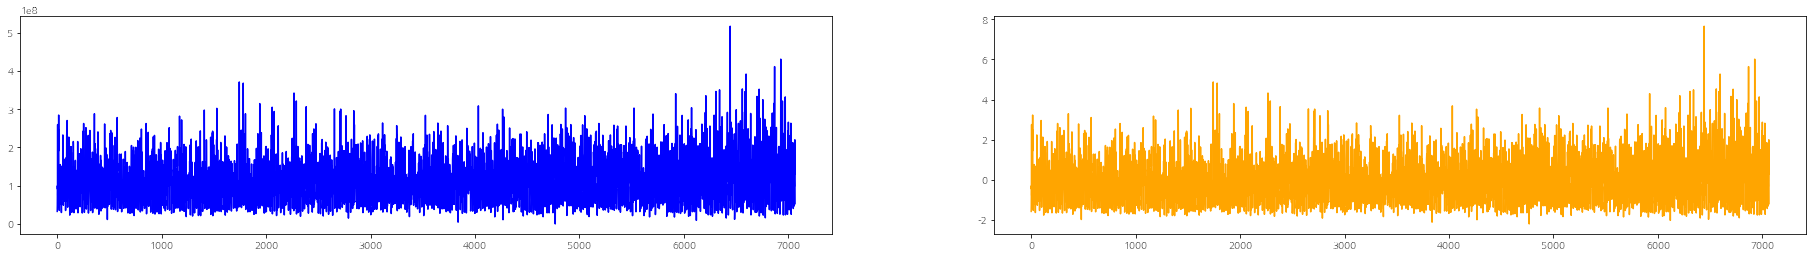

In [9]:
# 표준화 및 추이 파악
scaler = StandardScaler()
scaler.fit(df_hourly[['취급액']])
df_hourly['취급액_scaled'] = scaler.transform(df_hourly[['취급액']])

display(df_hourly.tail(3))

fig = plt.figure(figsize=(32, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(df_hourly['취급액'], color='blue')
ax2.plot(df_hourly['취급액_scaled'], color='orange')
plt.show()

In [28]:
# LSTM 데이터 생성
data = df_hourly['취급액_scaled'].values
X_train, X_test, y_train, y_test = createLstmData(data, 140, 0.9)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

6925
train: 6358 6358
test: 567 567
(6358, 140, 1) (6358, 1) (567, 140, 1) (567, 1)


In [29]:
# 모델 파라미터 설정
n_step = X_train.shape[1]
n_input = X_train.shape[2]
n_output = y_train.shape[1]
n_hidden = 512 # LSTM 히든 뉴런 수
n_batch = 128

In [31]:
# 모델 네트워크 구성
X_Input = Input(batch_shape=(None, n_step, n_input))
X_Lstm = Bidirectional(LSTM(n_hidden), merge_mode='concat')(X_Input)
y_output = Dense(n_output)(X_Lstm)

# 모델 컴파일
K.clear_session()
model = Model(X_Input, y_output)
model.compile(loss='mape', optimizer=optimizers.Adam(lr=0.001))
print("============ 모델 전체 구조 확인 ============")
print(model.summary())

============ 모델 전체 구조 확인 ============
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 140, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1052672   
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# custom early stopper
# 출처: https://stackoverflow.com/questions/46287403/is-there-a-way-to-implement-early-stopping-in-keras-only-after-the-first-say-1
# restore_best_weights 추가
class CustomStopper(keras.callbacks.EarlyStopping):
    def __init__(self, patience, monitor='val_loss', min_delta=0, verbose=1, mode='auto', start_epoch=100, restore_best_weights=True): # add argument for starting epoch
        super(CustomStopper, self).__init__()
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

In [32]:
# 모델 학습
# es = CustomStopper(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
# es = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True)
hist = model.fit(X_train, y_train,
                 validation_split=0.1,
                 epochs=300,
                 batch_size=n_batch,
                 shuffle=True)
                 # callbacks=[es])

Epoch 1/300
45/45 [==============================] - 1s 31ms/step - loss: 153.8950 - val_loss: 137.7724
Epoch 2/300
45/45 [==============================] - 1s 22ms/step - loss: 140.9297 - val_loss: 109.3148
Epoch 3/300
45/45 [==============================] - 1s 22ms/step - loss: 148.8256 - val_loss: 106.9608
Epoch 4/300
45/45 [==============================] - 1s 22ms/step - loss: 118.6113 - val_loss: 103.8869
Epoch 5/300
45/45 [==============================] - 1s 22ms/step - loss: 124.2373 - val_loss: 103.0134
Epoch 6/300
45/45 [==============================] - 1s 22ms/step - loss: 107.1409 - val_loss: 99.8586
Epoch 7/300
45/45 [==============================] - 1s 22ms/step - loss: 112.9652 - val_loss: 101.2097
Epoch 8/300
45/45 [==============================] - 1s 22ms/step - loss: 106.4990 - val_loss: 102.5633
Epoch 9/300
45/45 [==============================] - 1s 22ms/step - loss: 107.3787 - val_loss: 100.6431
Epoch 10/300
45/45 [==============================] - 1s 22ms/ste

In [35]:
# 예측
n_future = X_test.shape[0]
estimate = [y_train[-1][0]] # 예측값 저장할 배열
for i in range(n_future):
    x = X_test[i].reshape(1, n_step, 1)
    y_hat = model.predict(x)[0][0]
    estimate.append(y_hat)

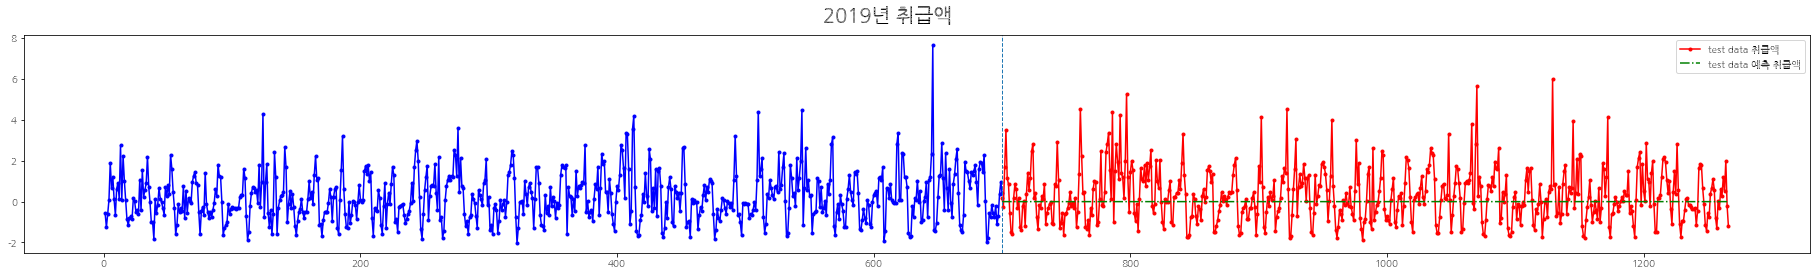

In [36]:
# 예측 결과 그래프
ax1 = np.arange(1, len(y_train[-700:])+1)
ax2 = np.arange(len(y_train[-700:]), len(y_train[-700:])+len(y_test))

plt.figure(figsize=(32, 4))
plt.plot(ax1, y_train[-700:].flatten(), 'b-o', color='blue', markersize=3)
plt.plot(ax2, y_test.flatten(), 'b-o', color='red', markersize=3, label='test data 취급액')
plt.plot(ax2,  estimate[1:], linestyle='dashdot', color='green', label='test data 예측 취급액')
plt.axvline(x=ax1[-1], linestyle='dashed', linewidth=1)
plt.suptitle('2019년 취급액', size=20)
plt.legend()
plt.show()